In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_json('json/corpus.json')
df = df.reset_index().drop(columns = ['index'])

In [3]:
df.head(1)

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,"[adult standards, brill building pop, bubblegu...",[1958-08-08],[1],1


In [7]:
all_weeks = []

for ind, item in df['weeks_list'].iteritems():
    for week in item:
        all_weeks.append(week)
        
weeks = pd.Series(all_weeks).value_counts().index

In [12]:
weeks = sorted(weeks)[1:]

In [17]:
features = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
            'mode': [], 'energy': [], 'valence': []}

keys = features.keys()

for week in weeks :
    week_features = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
                     'mode': [], 'energy': [], 'valence': []}
        
    for ind, row in df.iterrows():
        if week in row['weeks_list']: 
            for key in keys:
                week_features[key].append(row[key])
    
    for key in keys:
        features[key].append(week_features[key])

In [93]:
def mean_confidence_interval(data, confidence = 0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [94]:
def compute_bounds(features, feature):
    
    lower_bound, mean, upper_bound = [], [], []

    # Compute the 95% confidence interval
    for week in range(len(features[feature])):
        m, lb, ub = mean_confidence_interval(features[feature][week])
    
        lower_bound.append(lb)
        mean.append(m)
        upper_bound.append(ub)
        
    return lower_bound, mean, upper_bound

In [95]:
def plot_feature_evolution(features, feature, color = 'b'):
    
    sns.set(rc={'figure.figsize':(25,10)})
    sns.set_style("ticks")
    
    years = np.arange(1959, 1997)
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    
    name = feature.replace('_', ' ').capitalize()
    plt.xticks(np.arange(0, (len(years))*48, 48), years, rotation = 'vertical')
    plt.xlabel('Weeks')
    plt.ylabel(name)
    plt.title(name + ' change at week granularity \n')

    return plt

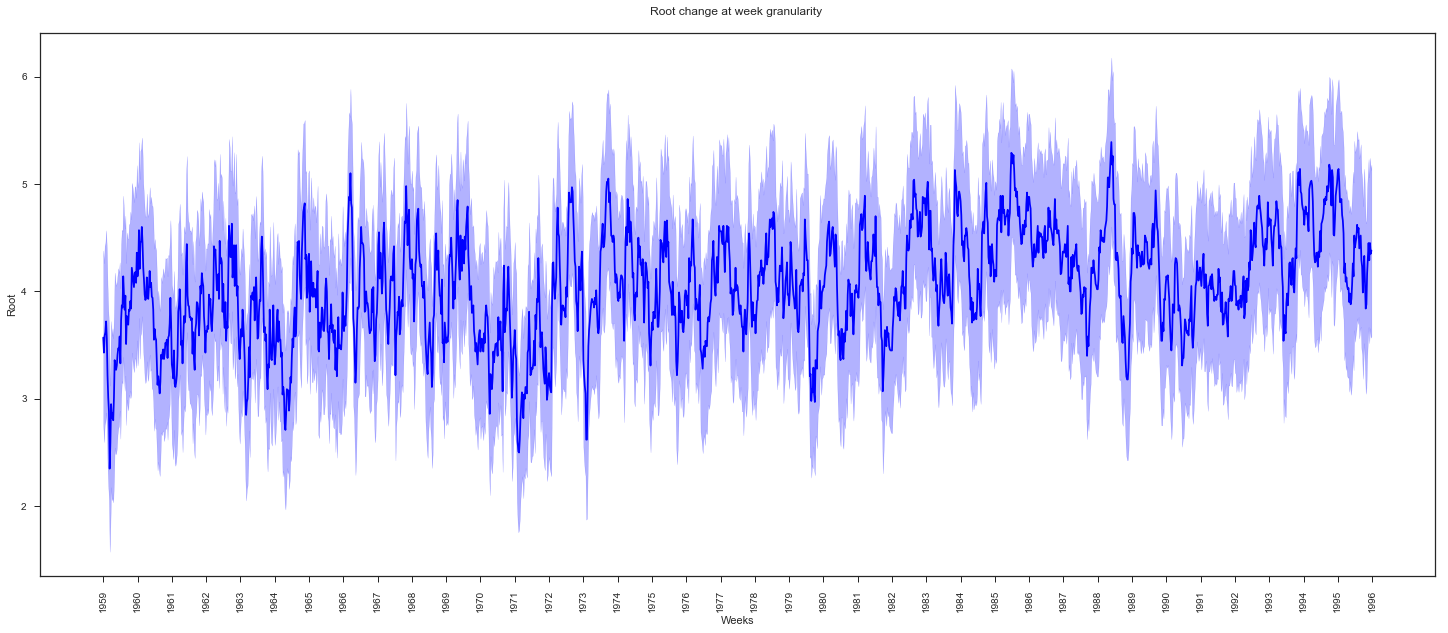

In [96]:
plot_feature_evolution(features, 'root');

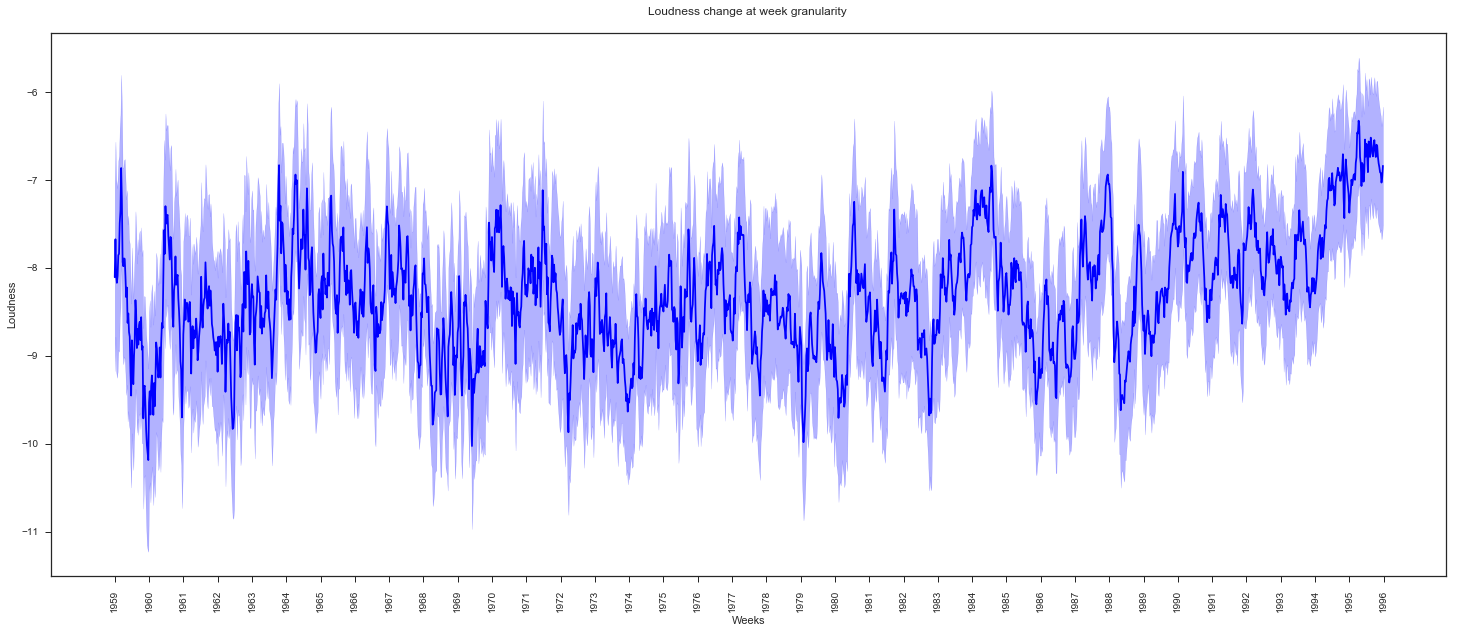

In [97]:
plot_feature_evolution(features, 'loudness');

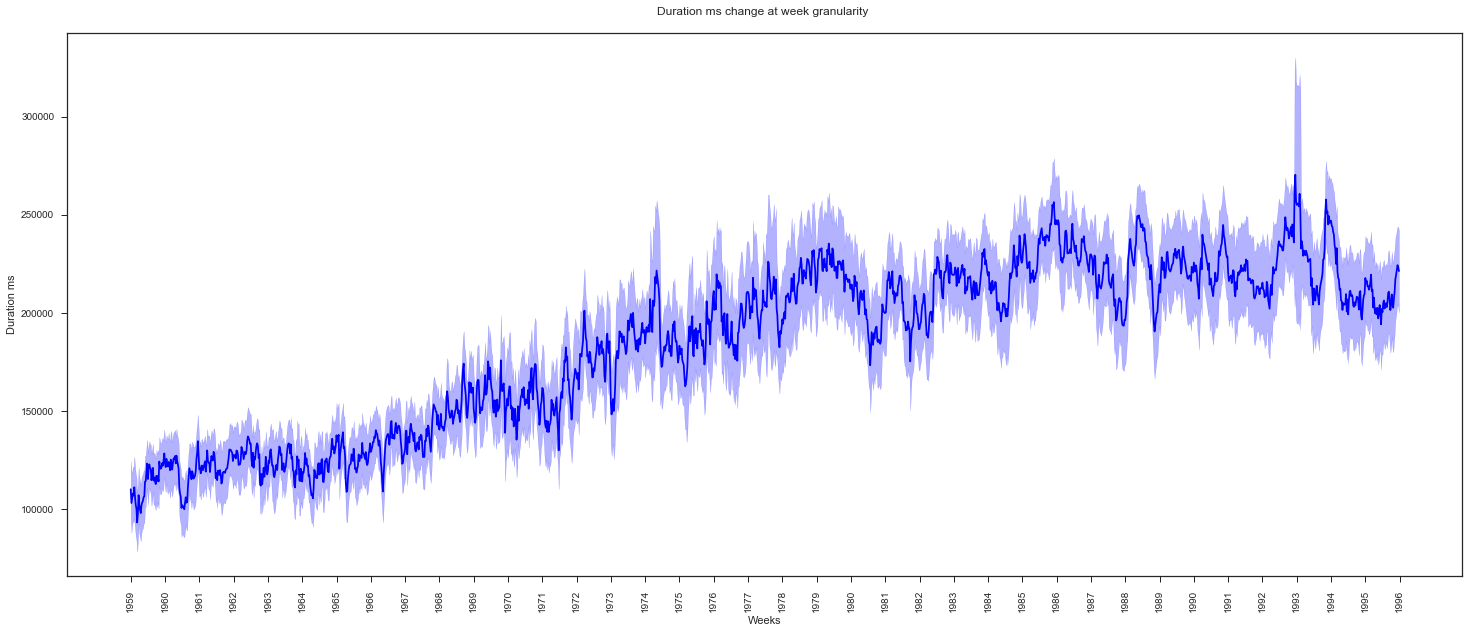

In [98]:
plot_feature_evolution(features, 'duration_ms');

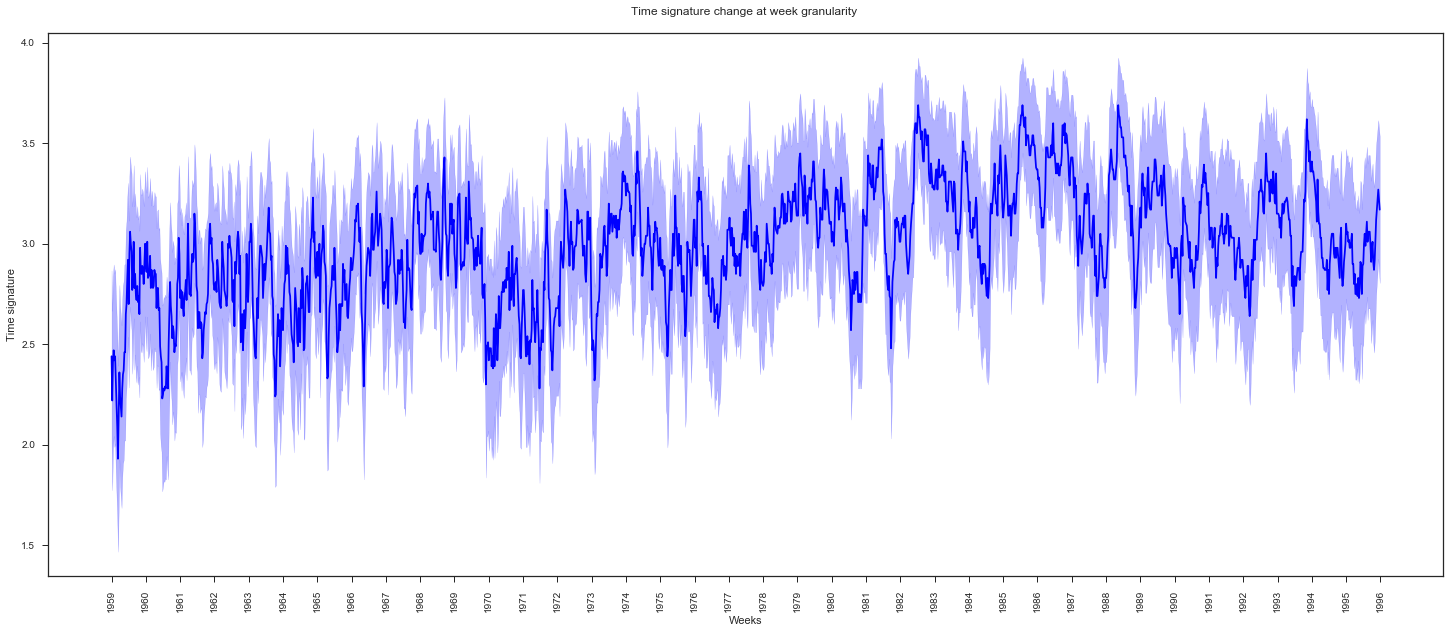

In [99]:
plot_feature_evolution(features, 'time_signature');

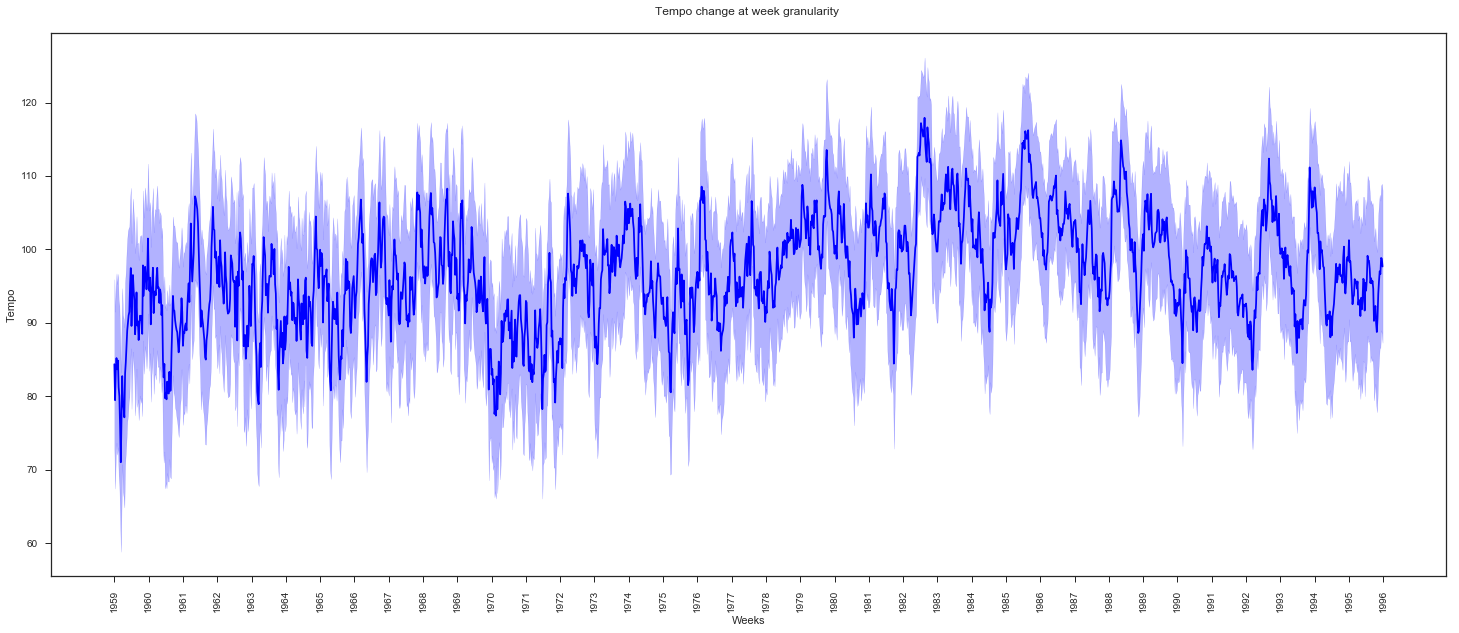

In [100]:
plot_feature_evolution(features, 'tempo');

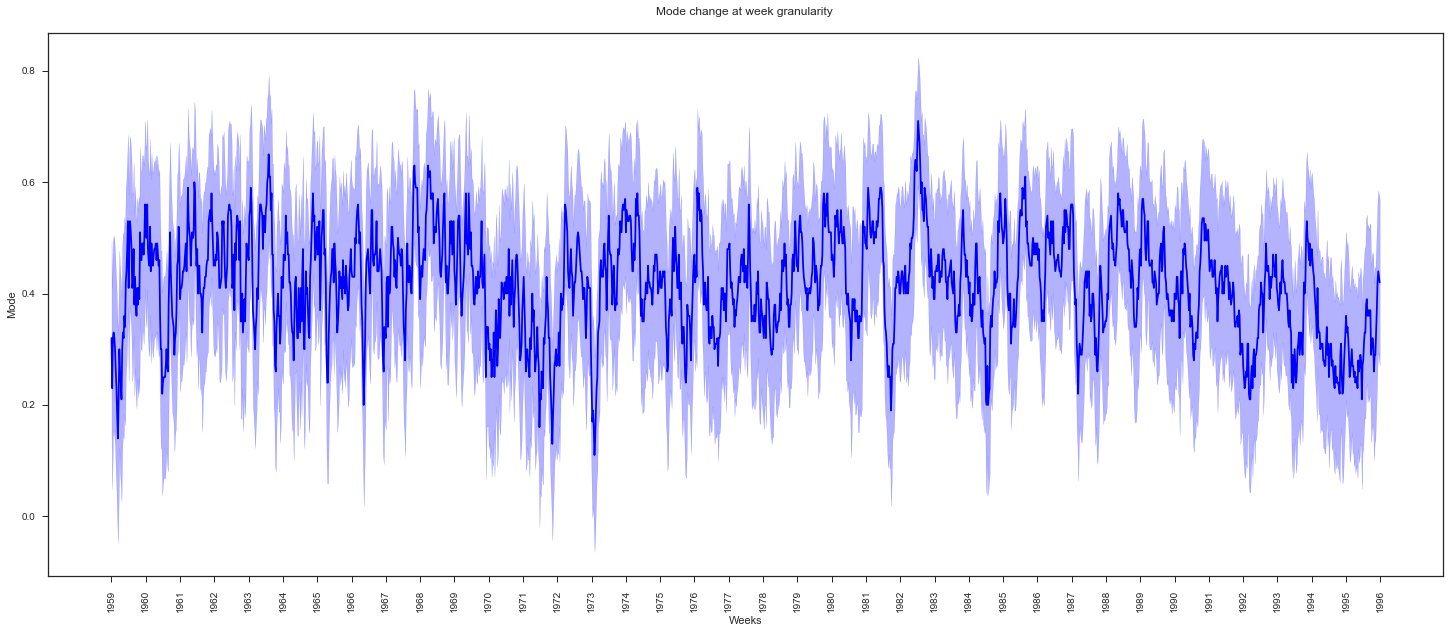

In [101]:
plot_feature_evolution(features, 'mode');

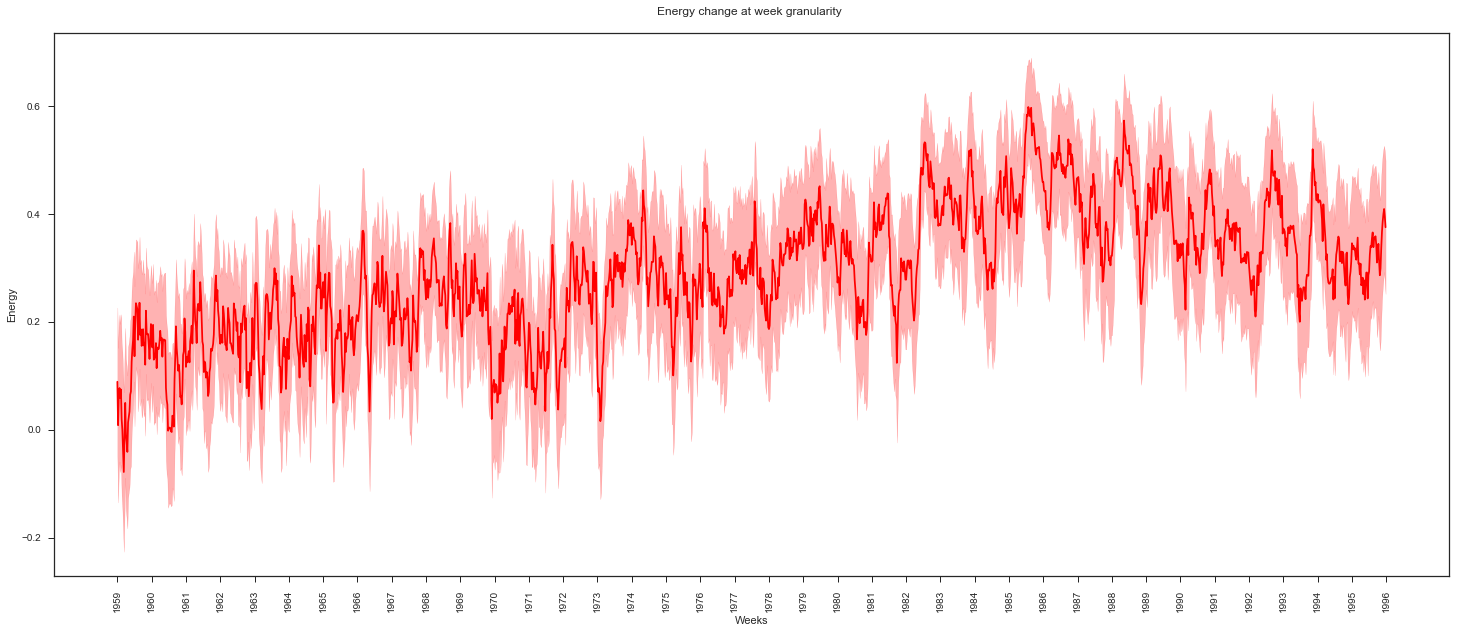

In [102]:
plot_feature_evolution(features, 'energy', color = 'r');

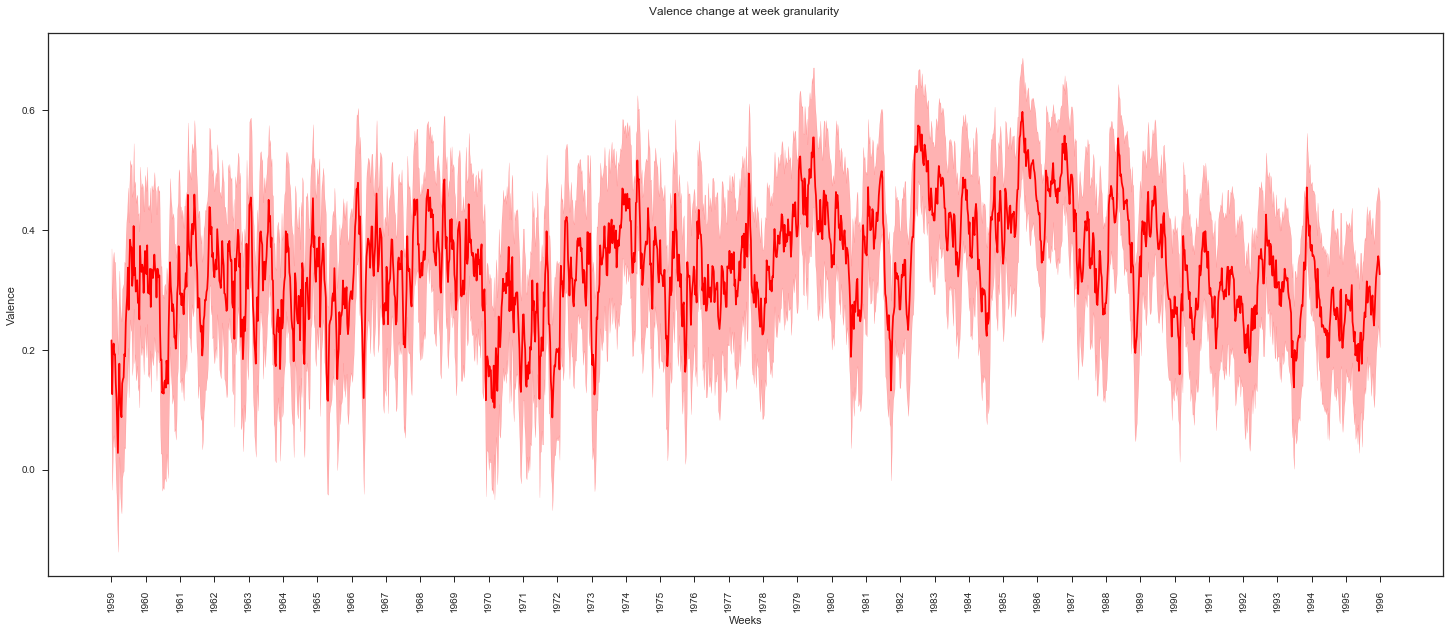

In [103]:
plot_feature_evolution(features, 'valence', color = 'r');

In [104]:
trend = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
            'mode': [], 'energy': [], 'valence': []}

for key in trend.keys():
    for i in range(len(weeks)):
        trend[key].append(np.mean(features[key][i]))

In [105]:
df_trend = pd.DataFrame(trend)

In [110]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style("ticks")

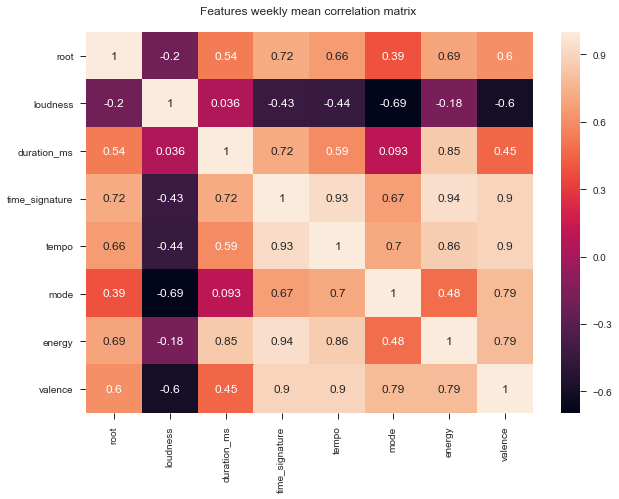

In [111]:
sns.heatmap(df_trend.corr(), annot=True).set_title('Features weekly mean correlation matrix \n');